<a href="https://colab.research.google.com/github/manasuii/Machine-Learning-Fundamentals/blob/main/1Dpoisson_equation_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [12]:
#step no 1. Define the neural network

def create_model():
  model={
      'dense1':tf.keras.layers.Dense(50,activation='tanh'),
      'dense2':tf.keras.layers.Dense(50,activation='tanh'),
      'dense3':tf.keras.layers.Dense(50,activation='tanh'),
      'output_layer':tf.keras.layers.Dense(1)
  }
  return model



def call_model(model,x):
  x=model['dense1'](x)
  x=model['dense2'](x)
  x=model['dense3'](x)
  x=model['output_layer'](x)
  return x



In [13]:
# step no 2 compute the gradients
def pde(x,model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y_pred=call_model(model,x)
    y_x=tape.gradient(y_pred,x)
  y_xx=tape.gradient(y_x,x)
  del tape
  return y_xx+np.pi**2*tf.sin(np.pi*x)

In [14]:
#step no 3 define the lo function
def loss(model,x,x_bc,y_bc):
  res=pde(x,model)
  loss_pde=tf.reduce_mean(tf.square(res))
  y_bc_pred=call_model(model,x_bc)
  loss_bc=tf.reduce_mean(tf.square(y_bc-y_bc_pred))
  return loss_pde+loss_bc

In [15]:
def train_step(model, x, x_bc, y_bc, optimizer):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, x_bc, y_bc)

    # flatten variables first
    variables = [var
                 for layer in model.values()
                 for var in layer.trainable_variables]

    # compute gradients directly for the flat list
    grads = tape.gradient(loss_value, variables)

    optimizer.apply_gradients(zip(grads, variables))

    return loss_value


In [19]:
#setting up the problem
#generating the training data

x_train=np.linspace(-1,1,100).reshape(-1,1)
x_train=tf.convert_to_tensor(x_train,dtype=tf.float32)

#boundary data
x_bc=np.array([[-1.0],[1.0]],dtype=np.float32)
y_bc=np.array([[0.0],[0.0]],dtype=np.float32)
x_bc=tf.convert_to_tensor(x_bc,dtype=tf.float32)
y_bc=tf.convert_to_tensor(y_bc,dtype=tf.float32)

model=create_model()

lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

epochs=2000
for epoch in range(epochs):
  loss_value=train_step(model,x_train,x_bc,y_bc,optimizer)
  if epoch%1000==0:
    print(f'epoch:{epoch},loss:{loss_value.numpy()}')





epoch:0,loss:48.30862045288086
epoch:1000,loss:0.00015238078776746988


In [20]:
#predict the olution
x_test=np.linspace(-1,1,1000).reshape(-1,1)
x_test=tf.convert_to_tensor(x_test,dtype=tf.float32)
y_pred=call_model(model,x_test).numpy()

y_true=np.sin(np.pi*x_test)

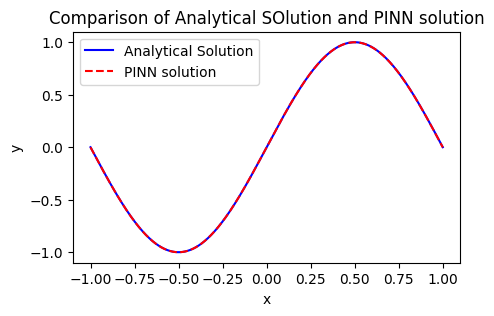

In [23]:
#plot the results
plt.figure(figsize=(5,3))
plt.plot(x_test,y_true,'b-',label="Analytical Solution")
plt.plot(x_test,y_pred,'r--',label="PINN solution")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical SOlution and PINN solution')
plt.show()